In [1]:
cd ..

/home/wesg/research/ordinal-probing


In [2]:
# autoreload
%load_ext autoreload
%autoreload 2

import numpy as np
import sklearn
import pandas as pd
import matplotlib.pyplot as plt
import torch
from scipy.stats import rankdata
from load import load_model
import datasets
import seaborn as sns
import pickle


from transformers import AutoTokenizer, AutoModelForCausalLM
import torch 


from feature_datasets.common import *
from save_activations import load_activation_probing_dataset
from model_composition import *

import utils
import os

from probe_experiment import load_probe_results, get_target_values
from analysis.generalization import*
from analysis.probe_plots import *

%matplotlib inline

In [3]:
ENTITY_INFO = {
    'world_place': ('coords', 'coords', 'entity_type'),
    'us_place': ('coords', 'coords', 'entity_type'),
    'nyc_place': ('where_nyc', 'coords', 'facility_t_name'),
    'headline': ('empty', 'pub_date', 'new_desk'),
    'art': ('release', 'release_date', 'entity_type'),
    'historical_figure': ('when', 'death_year', 'occupation')
}

In [4]:
entity_name = 'world_place'
model_name = 'Llama-2-70b-hf'

entity_df = load_entity_data(entity_name)

In [5]:
corr_df = pd.read_csv(f'results/top_neurons/{model_name}/{entity_name}').sort_values('abs_corr', ascending=False)
corr_df.head(5)

feature  weight  layer  neuron      corr  abs_corr
49       lat    W_in     48   28450  0.840298  0.840298
99       lat  W_gate     42   21918  0.803835  0.803835
149      lat   W_out     42   21918  0.788098  0.788098
48       lat    W_in     42   16912  0.787293  0.787293
549  abs_lon  W_gate     48   17690  0.770642  0.770642

In [6]:
models = [ 'Llama-2-7b-hf', 'Llama-2-13b-hf', 'Llama-2-70b-hf']
entities = ['world_place', 'us_place', 'headline', 'art', 'historical_figure']
corr_dfs = []
for entity_name in entities:
    for model_name in models:
        print(model_name, entity_name)
        corr_df = pd.read_csv(f'results/top_neurons/{model_name}/{entity_name}').sort_values('abs_corr', ascending=False)
        corr_df['model'] = model_name
        corr_df['entity_name'] = entity_name
        corr_dfs.append(corr_df)
        #display(corr_df.head(3))
corr_df = pd.concat(corr_dfs)

Llama-2-7b-hf world_place
Llama-2-13b-hf world_place
Llama-2-70b-hf world_place
Llama-2-7b-hf us_place
Llama-2-13b-hf us_place
Llama-2-70b-hf us_place
Llama-2-7b-hf headline
Llama-2-13b-hf headline
Llama-2-70b-hf headline
Llama-2-7b-hf art
Llama-2-13b-hf art
Llama-2-70b-hf art
Llama-2-7b-hf historical_figure
Llama-2-13b-hf historical_figure
Llama-2-70b-hf historical_figure


In [13]:
corr_df.loc[(corr_df.entity_name == entity_name) & (corr_df.model == model_name)]

feature  weight  layer  neuron      corr  abs_corr           model  \
99     time  W_gate     43    9783 -0.765767  0.765767  Llama-2-70b-hf   
98     time  W_gate     47    1872 -0.742378  0.742378  Llama-2-70b-hf   
97     time  W_gate     40   21791 -0.735572  0.735572  Llama-2-70b-hf   
96     time  W_gate     42   24878 -0.714392  0.714392  Llama-2-70b-hf   
95     time  W_gate     44   15898 -0.712120  0.712120  Llama-2-70b-hf   
..      ...     ...    ...     ...       ...       ...             ...   
104    time   W_out     46   22855  0.581995  0.581995  Llama-2-70b-hf   
103    time   W_out     61   14375  0.581701  0.581701  Llama-2-70b-hf   
102    time   W_out     24   22831  0.581173  0.581173  Llama-2-70b-hf   
101    time   W_out     39    7692 -0.580693  0.580693  Llama-2-70b-hf   
100    time   W_out     72   12666 -0.580487  0.580487  Llama-2-70b-hf   

           entity_name  
99   historical_figure  
98   historical_figure  
97   historical_figure  
96   historical_figure  
95   historical_figure  
..                 ...  
104  historical_figure  
103  historical_figure  
102  historical_figure  
101  historical_figure  
100  historical_figure  

[150 rows x 8 columns]

In [7]:
from model_composition import *
def get_neuron_and_projection(entity_activations, model, weight, layer, neuron):
    offset = (1 if weight != 'W_out' else 0)
    acts = entity_activations[layer - offset]

    if weight == 'W_in':
        weights = model.model.layers[layer].mlp.up_proj.weight
    elif weight == 'W_gate':
        weights = model.model.layers[layer].mlp.gate_proj.weight
    elif weight == 'W_out':
        weights = model.model.layers[layer].mlp.down_proj.weight.T
    else:
        raise ValueError(f'Invalid weight: {weight}')
    
    if weight != 'W_out':
        acts = RMSnorm(acts.float())
        
    neuron_weight = weights[neuron]
    proj = (acts.float() @ neuron_weight.T.float()).numpy()
    return neuron_weight, proj

In [27]:
torch.set_grad_enabled(False)

neuron_dict = {}
composition_dict = {}
for model_name in models:
    model = AutoModelForCausalLM.from_pretrained(f"meta-llama/{model_name}", torch_dtype=torch.float16)
    n_layers = model.config.num_hidden_layers
    for entity_name in entities:
        entity_df = load_entity_data(entity_name)
        entity_activations = {
            l: load_activation_probing_dataset(model_name, entity_name, ENTITY_INFO[entity_name][0], l).dequantize().to(torch.float16) 
            for l in range(n_layers)
        }
        print(model_name, entity_name)
        sub_df = corr_df.loc[(corr_df.entity_name == entity_name) & (corr_df.model == model_name)].head(10)
        for _, row in sub_df.iterrows():
            neuron = row['neuron']
            layer = row['layer']
            weight = row['weight']
            neuron_weight, proj = get_neuron_and_projection(entity_activations, model, weight, layer, neuron)
            neuron_dict[(model_name, entity_name, neuron, layer, weight)] = neuron_weight.detach().numpy()
            composition_dict[(model_name, entity_name, neuron, layer, weight)] = proj

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Llama-2-7b-hf world_place
Llama-2-7b-hf us_place
Llama-2-7b-hf headline
Llama-2-7b-hf art
Llama-2-7b-hf historical_figure


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Llama-2-13b-hf world_place
Llama-2-13b-hf us_place
Llama-2-13b-hf headline
Llama-2-13b-hf art
Llama-2-13b-hf historical_figure


Loading checkpoint shards:   0%|          | 0/15 [00:00<?, ?it/s]

Llama-2-70b-hf world_place
Llama-2-70b-hf us_place
Llama-2-70b-hf headline
Llama-2-70b-hf art
Llama-2-70b-hf historical_figure


In [29]:
pickle.dump(neuron_dict, open('results/top_neurons/neuron_dict.pkl', 'wb'))
pickle.dump(composition_dict, open('results/top_neurons/composition_dict.pkl', 'wb'))

In [8]:
composition_dict = pickle.load(open('results/top_neurons/composition_dict.pkl', 'rb'))

In [31]:
corr_df.sort_values('abs_corr', ascending=False).groupby(['feature', 'entity_name']).head(5)#.head(30)

feature  weight  layer  neuron      corr  abs_corr           model  \
349  abs_lat    W_in     20    7573  0.846219  0.846219   Llama-2-7b-hf   
49       lat    W_in     48   28450  0.840298  0.840298  Llama-2-70b-hf   
449  abs_lat   W_out     20    7573  0.834630  0.834630   Llama-2-7b-hf   
49      time    W_in     43    9177  0.831220  0.831220  Llama-2-70b-hf   
299      lon   W_out     40   15804  0.825372  0.825372  Llama-2-70b-hf   
99      time  W_gate     43   16086 -0.825282  0.825282  Llama-2-70b-hf   
99       lat  W_gate     24     269  0.822923  0.822923  Llama-2-13b-hf   
599  abs_lon   W_out     21    7523  0.813743  0.813743  Llama-2-13b-hf   
49       lat    W_in     28    4341 -0.812926  0.812926  Llama-2-13b-hf   
149     time   W_out     43   23969  0.804059  0.804059  Llama-2-70b-hf   
99       lat  W_gate     42   21918  0.803835  0.803835  Llama-2-70b-hf   
98      time  W_gate     43    9177  0.802977  0.802977  Llama-2-70b-hf   
49       lat    W_in     20    7573  0.802126  0.802126   Llama-2-7b-hf   
148     time   W_out     46   19137 -0.794812  0.794812  Llama-2-70b-hf   
399  abs_lat  W_gate     19    5722 -0.780450  0.780450  Llama-2-13b-hf   
49      time    W_in     10    3254 -0.774873  0.774873   Llama-2-7b-hf   
549  abs_lon  W_gate     48   17690  0.770642  0.770642  Llama-2-70b-hf   
99      time  W_gate     54   12483  0.768236  0.768236  Llama-2-70b-hf   
99      time  W_gate     43    9783 -0.765767  0.765767  Llama-2-70b-hf   
599  abs_lon   W_out     48   17690 -0.761727  0.761727  Llama-2-70b-hf   
449  abs_lat   W_out     24     269  0.760786  0.760786  Llama-2-13b-hf   
599  abs_lon   W_out     18    2979  0.757745  0.757745   Llama-2-7b-hf   
549  abs_lon  W_gate     18    2979  0.755578  0.755578   Llama-2-7b-hf   
349  abs_lat    W_in     48   28450  0.755310  0.755310  Llama-2-70b-hf   
298      lon   W_out     44    3686  0.751479  0.751479  Llama-2-70b-hf   
49      time    W_in     37    8352  0.751285  0.751285  Llama-2-70b-hf   
99      time  W_gate     19    8395  0.747533  0.747533  Llama-2-13b-hf   
98      time  W_gate     43    7377  0.745786  0.745786  Llama-2-70b-hf   
149     time   W_out     54   12483  0.744828  0.744828  Llama-2-70b-hf   
99      time  W_gate     10    3254 -0.743963  0.743963   Llama-2-7b-hf   
49      time    W_in     14   11841  0.742899  0.742899  Llama-2-13b-hf   
148     time   W_out     42   26864 -0.742020  0.742020  Llama-2-70b-hf   
249      lon  W_gate     23    9458  0.741156  0.741156   Llama-2-7b-hf   
249      lon  W_gate     17    1467 -0.738467  0.738467  Llama-2-70b-hf   
248      lon  W_gate     17    9424 -0.735486  0.735486  Llama-2-70b-hf   
199      lon    W_in     17   18767 -0.723479  0.723479  Llama-2-70b-hf   
99       lat  W_gate     39   10326 -0.723032  0.723032  Llama-2-70b-hf   
49       lat    W_in     39   10326  0.714177  0.714177  Llama-2-70b-hf   
48       lat    W_in     18    9278 -0.696327  0.696327  Llama-2-70b-hf   
98       lat  W_gate     18    9278  0.686712  0.686712  Llama-2-70b-hf   
149      lat   W_out     48    2631  0.680333  0.680333  Llama-2-70b-hf   
199      lon    W_in     43   12689 -0.658088  0.658088  Llama-2-70b-hf   
299      lon   W_out     21     696  0.620557  0.620557   Llama-2-7b-hf   
198      lon    W_in     45    5562  0.619210  0.619210  Llama-2-70b-hf   
249      lon  W_gate     21    6194  0.609631  0.609631  Llama-2-13b-hf   

           entity_name  
349        world_place  
49         world_place  
449        world_place  
49                 art  
299           us_place  
99                 art  
99         world_place  
599        world_place  
49         world_place  
149                art  
99         world_place  
98                 art  
49         world_place  
148                art  
399        world_place  
49   historical_figure  
549        world_place  
99            headline  
99   historical_figure  
599        world_place  
449        world_place  
599 

In [10]:
entity_dfs = {
    entity: load_entity_data(entity) for entity in entities
}

In [10]:
activation = composition_dict[('Llama-2-7b-hf', 'world_place', 7573, 20, 'W_in')]

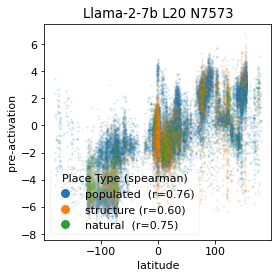

In [124]:
#activation = composition_dict[('Llama-2-13b-hf', 'world_place', 269, 24, 'W_gate')] good
activation = composition_dict[('Llama-2-7b-hf', 'world_place', 9458, 23, 'W_gate')]

fig, ax = plt.subplots(1, 1, figsize=(4, 4))

entity_df = entity_dfs['world_place']
feature_name = 'longitude'
group_order = ['populated_place', 'structure', 'natural_place']
legend_handles = []
for name in group_order:
    group_df = entity_df.loc[entity_df.entity_type == name]
    target = group_df[feature_name].values
    spearman_corr = spearmanr(target, activation[group_df.index]).correlation
    sc = ax.scatter(target, activation[group_df.index], alpha=0.1, s=2, label=name)

    legend_handles.append(
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=sc.get_facecolor(), markersize=10, alpha=1,
                   label=f"{name.replace('_', ' ').replace('place', '')} (r={spearman_corr:.2f})")
    )
ax.set_xlabel('latitude')
ax.set_ylabel('pre-activation')
#ax.set_xlim(-50, 70)
#ax.set_ylim(-5, 7)
ax.legend(handles=legend_handles, title='Place Type (spearman)', framealpha=0.2, loc='lower left')
ax.set_title('Llama-2-7b L20 N7573')

plt.tight_layout()

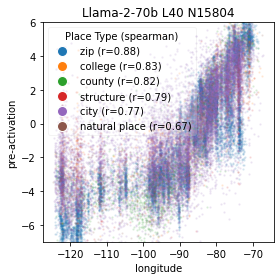

In [12]:
activation = composition_dict[('Llama-2-70b-hf', 'us_place', 15804, 40, 'W_out')]
fig, ax = plt.subplots(1, 1, figsize=(4, 4))

entity_df = entity_dfs['us_place']
feature_name = 'longitude'
group_order = ['zip', 'college', 'county', 'structure', 'city', 'natural_place']
legend_handles = []
for name in group_order:
    group_df = entity_df.loc[entity_df.entity_type == name]
    target = group_df[feature_name].values
    spearman_corr = spearmanr(target, activation[group_df.index]).correlation
    sc = ax.scatter(target, activation[group_df.index], alpha=0.1, s=2, label=name, zorder=1 if zip else 0)

    legend_handles.append(
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=sc.get_facecolor(), markersize=10, alpha=1,
                   label=f"{name.replace('_', ' ')} (r={spearman_corr:.2f})")
    )
ax.set_xlabel('longitude')
ax.set_ylabel('pre-activation')
#ax.set_xlim(-50, 70)
ax.set_ylim(-7, 6)
# turn off legend box
ax.legend(handles=legend_handles, title='Place Type (spearman)', framealpha=0.2)
ax.set_title('Llama-2-70b L40 N15804')

plt.tight_layout()

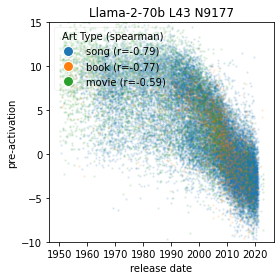

In [57]:
#activation = composition_dict[('Llama-2-70b-hf', 'art', 9177, 43, 'W_in')]
#activation = composition_dict[('Llama-2-70b-hf', 'art', 23969, 43, 'W_out')]
activation = composition_dict[('Llama-2-70b-hf', 'art', 19137, 46, 'W_out')]
fig, ax = plt.subplots(1, 1, figsize=(4, 4))

entity_df = entity_dfs['art']
feature_name = 'release_date'
group_order = ['song', 'book', 'movie']
target = get_target_values(entity_df, 'release_date')
legend_handles = []
for name in group_order:
    group_df = entity_df.loc[entity_df.entity_type == name]
    target_date = pd.to_datetime(group_df[feature_name])
    spearman_corr = spearmanr(target[group_df.index], activation[group_df.index]).correlation
    sc = ax.scatter(target_date, activation[group_df.index], alpha=0.1, s=2, label=name)

    legend_handles.append(
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=sc.get_facecolor(), markersize=10, alpha=1,
                   label=f"{name.replace('_', ' ')} (r={spearman_corr:.2f})")
    )
ax.set_xlabel('release date')
ax.set_ylabel('pre-activation')
ax.set_ylim(-10, 15)
ax.legend(handles=legend_handles, title='Art Type (spearman)', loc='upper left', framealpha=0.2)
ax.set_title('Llama-2-70b L43 N9177')

plt.tight_layout()

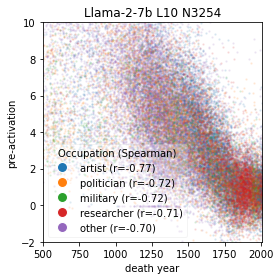

In [99]:
#activation = composition_dict[('Llama-2-7b-hf', 'historical_figure', 3254, 10, 'W_in')]
#activation = composition_dict[('Llama-2-13b-hf', 'historical_figure', 8395, 19, 'W_gate')]
#activation = composition_dict[('Llama-2-13b-hf', 'historical_figure', 11841, 14, 'W_in')]
activation = composition_dict[('Llama-2-7b-hf', 'historical_figure', 3254, 10, 'W_gate')]
fig, ax = plt.subplots(1, 1, figsize=(4, 4))

entity_df = entity_dfs['historical_figure']
display_names = {'artist': 'artist', 'politician': 'politician', 'researcher': 'researcher', 'military personnel': 'military'}
entity_df['display_occupation'] = entity_df.occupation.apply(lambda x: display_names.get(x, 'other'))
feature_name = 'death_year'
group_order = ['artist', 'politician', 'military', 'researcher', 'other']
target = get_target_values(entity_df, 'death_year')
legend_handles = []
for name in group_order:
    group_df = entity_df.loc[entity_df.display_occupation == name]
    target_date = group_df[feature_name].values
    spearman_corr = spearmanr(target[group_df.index], activation[group_df.index]).correlation
    sc = ax.scatter(target_date, activation[group_df.index], alpha=0.1, s=2, label=name, zorder=0 if name=='other' else 1)

    legend_handles.append(
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=sc.get_facecolor(), markersize=10, alpha=1,
                   label=f"{name.replace('_', ' ')} (r={spearman_corr:.2f})")
    )
ax.set_xlabel('death year')
ax.set_ylabel('pre-activation')
ax.set_ylim(-2, 10)
ax.set_xlim(500, 2005)
ax.legend(handles=legend_handles, title='Occupation (Spearman)', loc='lower left', framealpha=0.2)
ax.set_title('Llama-2-7b L10 N3254')

plt.tight_layout()

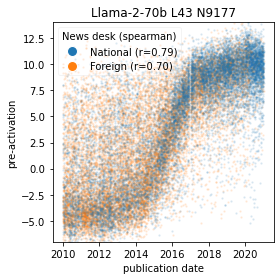

In [97]:
# Headlines
activation = composition_dict[('Llama-2-70b-hf', 'headline', 12483, 54, 'W_gate')]

fig, ax = plt.subplots(1, 1, figsize=(4, 4))

entity_df = entity_dfs['headline']
feature_name = 'pub_date'
news_desk_display = {'Foreign': 'Foreign'}
group_order = ['National', 'Foreign']
entity_df['news_desk_display'] = entity_df.news_desk.apply(lambda x: news_desk_display.get(x, 'National'))
target = get_target_values(entity_df, feature_name)
legend_handles = []
for name in group_order:
    group_df = entity_df.loc[entity_df.news_desk_display == name]
    target_date = pd.to_datetime(group_df[feature_name])
    spearman_corr = spearmanr(target[group_df.index], activation[group_df.index]).correlation
    sc = ax.scatter(target_date, activation[group_df.index], alpha=0.1, s=2, label=name, zorder=2 if name == 'National' else 1)

    legend_handles.append(
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=sc.get_facecolor(), markersize=10, alpha=1,
                   label=f"{name.replace('_', ' ')} (r={spearman_corr:.2f})")
    )
ax.set_xlabel('publication date')
ax.set_ylabel('pre-activation')
ax.set_ylim(-7, 14)
ax.legend(handles=legend_handles, title='News desk (spearman)', loc='upper left', framealpha=0.2)
ax.set_title('Llama-2-70b L43 N9177')

plt.tight_layout()

In [58]:
entity_df = entity_dfs['headline']
#entity_df['display_occupation']

In [68]:
entity_df.groupby(['news_desk', 'year']).count().headline.unstack()

year          2010    2011    2012    2013    2014    2015    2016    2017  \
news_desk                                                                    
Foreign     1458.0  1667.0  1596.0  1688.0  1872.0  1860.0  1431.0  1316.0   
National     804.0   732.0  1011.0   903.0   870.0  1066.0  1339.0   953.0   
Obits          2.0     2.0     2.0     1.0     NaN     4.0     2.0    78.0   
Politics       NaN     NaN     4.0     1.0     NaN    12.0    14.0     5.0   
Washington     NaN     NaN     8.0    10.0     NaN     1.0     NaN   277.0   

year          2018   2019   2020  
news_desk                         
Foreign     1067.0  979.0  555.0  
National     283.0  262.0  500.0  
Obits        151.0  184.0  281.0  
Politics     109.0  184.0  322.0  
Washington   883.0  819.0  821.0

In [61]:
entity_df.news_desk.value_counts().index

Index(['Foreign', 'National', 'Washington', 'Obits', 'Politics'], dtype='object', name='news_desk')

In [93]:
np.random.randint(1, 3, size=len(target_date))

array([2, 2, 1, ..., 1, 2, 1])

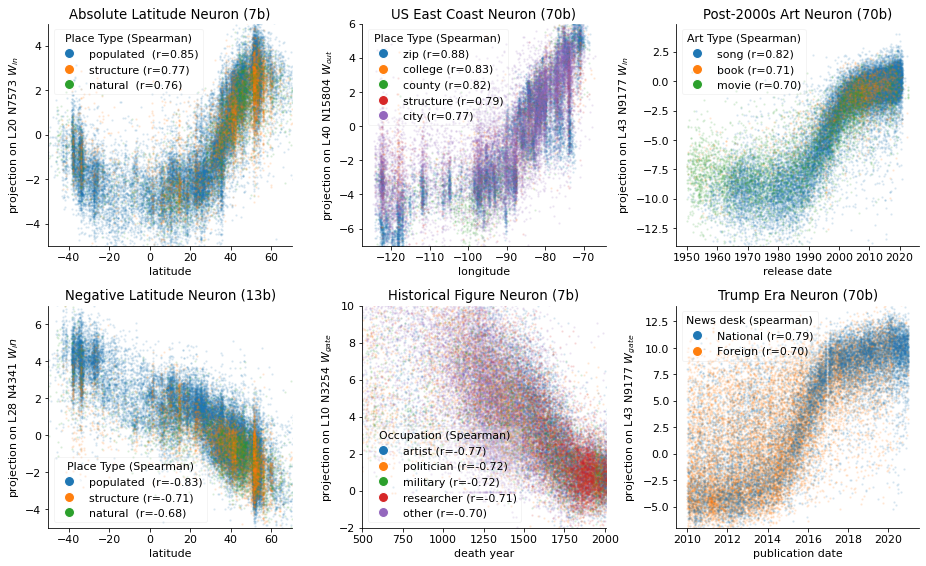

In [119]:
fig, axs = plt.subplots(2, 3, figsize=(13, 8))

plt.rcParams.update({'font.size': 11})

# World lat
ax = axs[0, 0]
activation = composition_dict[('Llama-2-7b-hf', 'world_place', 7573, 20, 'W_in')]
entity_df = entity_dfs['world_place']
feature_name = 'latitude'
group_order = ['populated_place', 'structure', 'natural_place']
legend_handles = []
for name in group_order:
    group_df = entity_df.loc[entity_df.entity_type == name]
    target = group_df[feature_name].values
    spearman_corr = spearmanr(np.abs(target), activation[group_df.index]).correlation
    sc = ax.scatter(target, activation[group_df.index], alpha=0.1, s=2, label=name)

    legend_handles.append(
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=sc.get_facecolor(), markersize=10, alpha=1,
                   label=f"{name.replace('_', ' ').replace('place', '')} (r={spearman_corr:.2f})")
    )
ax.set_xlabel('latitude')
ax.set_ylabel('projection on L20 N7573 $W_{in}$')
ax.set_xlim(-50, 70)
ax.set_ylim(-5, 5)
ax.legend(handles=legend_handles, title='Place Type (Spearman)', framealpha=0.2)
ax.set_title('Absolute Latitude Neuron (7b)')


# US lon
ax = axs[0, 1]
activation = composition_dict[('Llama-2-70b-hf', 'us_place', 15804, 40, 'W_out')]
entity_df = entity_dfs['us_place']
feature_name = 'longitude'
group_order = ['zip', 'college', 'county', 'structure', 'city']
legend_handles = []
for name in group_order:
    group_df = entity_df.loc[entity_df.entity_type == name]
    target = group_df[feature_name].values
    spearman_corr = spearmanr(target, activation[group_df.index]).correlation
    sc = ax.scatter(target, activation[group_df.index], alpha=0.1, s=2, label=name, zorder=1 if zip else 0)

    legend_handles.append(
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=sc.get_facecolor(), markersize=10, alpha=1,
                   label=f"{name.replace('_', ' ')} (r={spearman_corr:.2f})")
    )
ax.set_xlabel('longitude')
ax.set_ylabel('projection on L40 N15804 $W_{out}$')
#ax.set_xlim(-50, 70)
ax.set_ylim(-7, 6)
# turn off legend box
ax.legend(handles=legend_handles, title='Place Type (Spearman)', framealpha=0.2)
ax.set_title('US East Coast Neuron (70b)')


# Art release date
ax = axs[0, 2]
activation = composition_dict[('Llama-2-70b-hf', 'art', 9177, 43, 'W_in')]
entity_df = entity_dfs['art']
feature_name = 'release_date'
group_order = ['song', 'book', 'movie']
target = get_target_values(entity_df, 'release_date')
legend_handles = []
for name in group_order:
    group_df = entity_df.loc[entity_df.entity_type == name]
    target_date = pd.to_datetime(group_df[feature_name])
    spearman_corr = spearmanr(target[group_df.index], activation[group_df.index]).correlation
    sc = ax.scatter(target_date, activation[group_df.index], alpha=0.1, s=2, label=name)

    legend_handles.append(
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=sc.get_facecolor(), markersize=10, alpha=1,
                   label=f"{name.replace('_', ' ')} (r={spearman_corr:.2f})")
    )
ax.set_xlabel('release date')
ax.set_ylabel('projection on L43 N9177 $W_{in}$')
ax.set_ylim(-14, 4.9)
ax.legend(handles=legend_handles, title='Art Type (Spearman)', loc='upper left', framealpha=0.2)
ax.set_title('Post-2000s Art Neuron (70b)')


# World neg lat
activation = composition_dict[('Llama-2-13b-hf', 'world_place', 4341, 28, 'W_in')]

ax = axs[1, 0]
entity_df = entity_dfs['world_place']
feature_name = 'latitude'
group_order = ['populated_place', 'structure', 'natural_place']
legend_handles = []
for name in group_order:
    group_df = entity_df.loc[entity_df.entity_type == name]
    target = group_df[feature_name].values
    spearman_corr = spearmanr(target, activation[group_df.index]).correlation
    sc = ax.scatter(target, activation[group_df.index], alpha=0.1, s=2, label=name)

    legend_handles.append(
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=sc.get_facecolor(), markersize=10, alpha=1,
                   label=f"{name.replace('_', ' ').replace('place', '')} (r={spearman_corr:.2f})")
    )
ax.set_xlabel('latitude')
ax.set_ylabel('projection on L28 N4341 $W_in$')
ax.set_xlim(-50, 70)
ax.set_ylim(-5, 7)
ax.legend(handles=legend_handles, title='Place Type (Spearman)', framealpha=0.2, loc='lower left')
ax.set_title('Negative Latitude Neuron (13b)')


ax = axs[1, 1]
activation = composition_dict[('Llama-2-7b-hf', 'historical_figure', 3254, 10, 'W_gate')]
entity_df = entity_dfs['historical_figure']
display_names = {'artist': 'artist', 'politician': 'politician', 'researcher': 'researcher', 'military personnel': 'military'}
entity_df['display_occupation'] = entity_df.occupation.apply(lambda x: display_names.get(x, 'other'))
feature_name = 'death_year'
group_order = ['artist', 'politician', 'military', 'researcher', 'other']
target = get_target_values(entity_df, 'death_year')
legend_handles = []
for name in group_order:
    group_df = entity_df.loc[entity_df.display_occupation == name]
    target_date = group_df[feature_name].values
    spearman_corr = spearmanr(target[group_df.index], activation[group_df.index]).correlation
    sc = ax.scatter(target_date, activation[group_df.index], alpha=0.1, s=2, label=name, zorder=0 if name=='other' else 1)

    legend_handles.append(
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=sc.get_facecolor(), markersize=10, alpha=1,
                   label=f"{name.replace('_', ' ')} (r={spearman_corr:.2f})")
    )
ax.set_xlabel('death year')
ax.set_ylabel('projection on L10 N3254 $W_{gate}$')
ax.set_ylim(-2, 10)
ax.set_xlim(500, 2005)
ax.legend(handles=legend_handles, title='Occupation (Spearman)', loc='lower left', framealpha=0.2)
ax.set_title('Historical Figure Neuron (7b)')


ax = axs[1, 2]
activation = composition_dict[('Llama-2-70b-hf', 'headline', 12483, 54, 'W_gate')]
entity_df = entity_dfs['headline']
feature_name = 'pub_date'
news_desk_display = {'Foreign': 'Foreign'}
group_order = ['National', 'Foreign']
entity_df['news_desk_display'] = entity_df.news_desk.apply(lambda x: news_desk_display.get(x, 'National'))
target = get_target_values(entity_df, feature_name)
legend_handles = []
for name in group_order:
    group_df = entity_df.loc[entity_df.news_desk_display == name]
    target_date = pd.to_datetime(group_df[feature_name])
    spearman_corr = spearmanr(target[group_df.index], activation[group_df.index]).correlation
    sc = ax.scatter(target_date, activation[group_df.index], alpha=0.1, s=2, label=name, zorder=2 if name == 'National' else 1)

    legend_handles.append(
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=sc.get_facecolor(), markersize=10, alpha=1,
                   label=f"{name.replace('_', ' ')} (r={spearman_corr:.2f})")
    )
ax.set_xlabel('publication date')
ax.set_ylabel('projection on L43 N9177 $W_{gate}$')
ax.set_ylim(-7, 14)
ax.legend(handles=legend_handles, title='News desk (spearman)', loc='upper left', framealpha=0.2)
ax.set_title('Trump Era Neuron (70b)')


for ax in axs.flatten():
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.savefig('figures/neuron_composition_2rows.png', bbox_inches='tight')

In [86]:
target_date

Series([], Name: release_date, dtype: datetime64[ns])

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4))

entity_df = entity_dfs['world_place']
group_order = ['populated_place', 'structure', 'natural_place']
for name in group_order:
    group_df = entity_df.loc[entity_df.entity_type == name]
    ax.scatter(group_df['latitude'].values, activation[group_df.index], alpha=0.1, s=2, label=name)
ax.set_xlabel('latitude')
ax.set_ylabel('pre-activation')
ax.set_xlim(-50, 70)
ax.set_ylim(-5, 5)

plt.tight_layout()

In [95]:
torch.set_grad_enabled(False)
model = AutoModelForCausalLM.from_pretrained(f"meta-llama/{model_name}", torch_dtype=torch.float16)

Loading checkpoint shards:   0%|          | 0/15 [00:00<?, ?it/s]

In [96]:

n_layers = model.config.num_hidden_layers
entity_df = load_entity_data(entity_name)
entity_activations = {
    l: load_activation_probing_dataset(model_name, entity_name, ENTITY_INFO[entity_name][0], l).dequantize().to(torch.float16) 
    for l in range(n_layers)
}


In [102]:
target.s

array([[-47.8603 , -15.8017 ],
       [ 80.6997 ,   7.43694],
       [-83.1767 ,  42.3121 ],
       ...,
       [109.     ,  73.75   ],
       [108.667  ,  -2.08333],
       [-78.7525 ,  45.2986 ]])

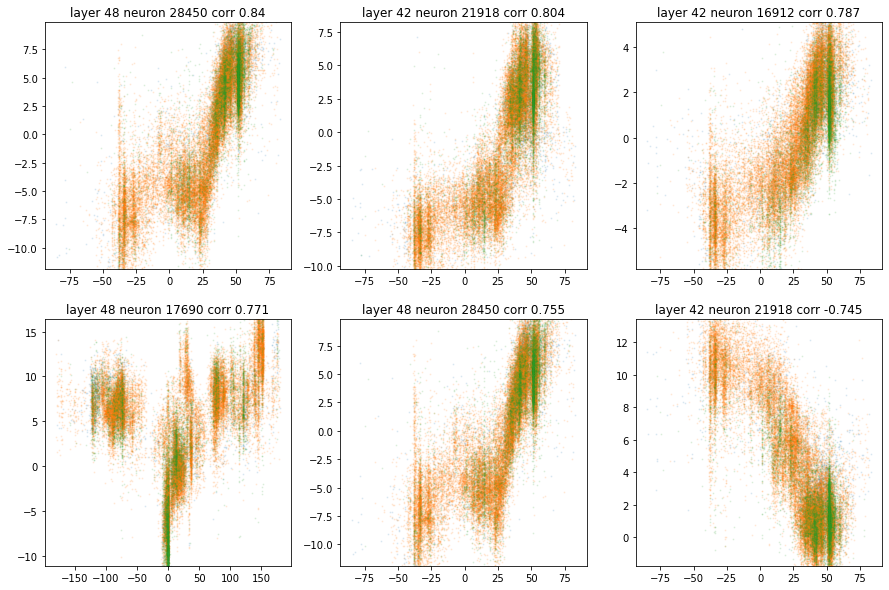

In [104]:
n_row, n_col = 2, 3
target = get_target_values(entity_df, ENTITY_INFO[entity_name][1])
fig, axes = plt.subplots(n_row, n_col, figsize=(15, 10))
for ix, (_, row) in enumerate(corr_df.query('weight != "W_out"').head(n_row * n_col).iterrows()):
    ax = axes[ix // n_col, ix % n_col]
    acts = entity_activations[row.layer - 1]
    if row.weight == 'W_in':
        weights = model.model.layers[row.layer].mlp.up_proj.weight
    else:
        weights = model.model.layers[row.layer].mlp.gate_proj.weight
    neuron = weights[row.neuron]
    proj = (acts.float() @ neuron.T.float()).numpy()
    space_target = target[:, 0] if row.feature.endswith('lon') else target[:, 1]
    for name, group in entity_df.groupby(ENTITY_INFO[entity_name][2]):
        ax.scatter(space_target[group.index], proj[group.index], s=1, alpha=0.1, label=name)
    #ax.scatter(target, proj, s=1, alpha=0.1)
    ax.set_title(f'layer {row.layer} neuron {row.neuron} corr {round(row["corr"], 3)}')
    # set ylim to be inner 99.9% of data
    ax.set_ylim(np.quantile(proj, 0.01), np.quantile(proj, 0.99))



In [ ]:
# main fig
# (70b, art, 43, 9177)
# (70b, US lon, 40, 15804)
# Llama-2-7b-hf world_place 20, 7573

In [53]:
from scipy.stats import spearmanr

In [70]:
#ENTITY_INFO[entity_name][2]
entity_name

'us_place'

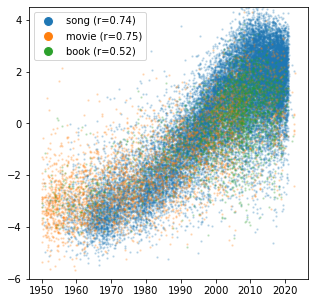

In [77]:
import matplotlib.pyplot as plt
from scipy.stats import spearmanr

fig, ax = plt.subplots(1, 1, figsize=(5, 5))


# Define the order of groups to be plotted
group_order = ['song', 'movie', 'book']
# Create an empty list to store handles for the legend
legend_handles = []

for name in group_order:  # Loop over the defined order
    group = entity_df[entity_df[ENTITY_INFO[entity_name][2]] == name]
    # Calculate the Spearman correlation
    spearman_corr = spearmanr(target[group.index], proj[group.index]).correlation
    # Create scatter plot
    sc = ax.scatter(pd.to_datetime(group.release_date), proj[group.index], s=2, alpha=0.2, label=name)
    
    # Create dummy scatter plot for legend with more visible markers
    legend_handles.append(
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=sc.get_facecolor(), markersize=10, alpha=1,
                   label=f"{name} (r={spearman_corr:.2f})")
    )
ax.legend(handles=legend_handles)

ax.set_ylim(-6, 4.5)
# Create a legend with the dummy handles

plt.show()


In [6]:
experiment_name = 'full_prompts'
model_name = 'Llama-2-7b-hf'
entity_type = 'art'
feature_name = 'release_date'
prompt = 'release'
probe_result = load_probe_results(experiment_name, model_name, entity_type, feature_name, prompt)
#us_probe_result = load_probe_results(experiment_name, model_name, 'us_place', feature_name, prompt)

In [4]:
# Load model directly
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch 

torch.set_grad_enabled(False)

tokenizer = AutoTokenizer.from_pretrained(f"meta-llama/{model_name}")
hf_model = AutoModelForCausalLM.from_pretrained(f"meta-llama/{model_name}")

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [7]:
from transformer_lens import HookedTransformer
model = HookedTransformer.from_pretrained(
    f"meta-llama/{model_name}", hf_model=hf_model, device="cpu", 
    fold_ln=False, center_writing_weights=False, center_unembed=True, tokenizer=tokenizer)

Using pad_token, but it is not set yet.


Loaded pretrained model meta-llama/Llama-2-7b-hf into HookedTransformer


In [6]:
from model_composition import *

In [9]:
from save_activations import load_activation_probing_dataset

n_layers = model.cfg.n_layers
entity_df = load_entity_data(entity_type)
entity_activations = {l: load_activation_probing_dataset(model_name, entity_type, prompt, l).dequantize() for l in range(n_layers)}


In [8]:
corr_df = place_neuron_correlations(model, probe_result, entity_df, entity_activations, top_k=50, start_layer=0)

ValueError: Length of values (50) does not match length of index (288)

In [9]:
lat_probes = torch.stack([
    torch.tensor(probe_result['probe_directions'][layer][:, 1])
    for layer in range(0, model.cfg.n_layers)
])
lat_probes = lat_probes / lat_probes.norm(dim=1, keepdim=True)

In [11]:
W_norm = (model.W_in / model.W_in.norm(dim=1,
                  keepdim=True)).swapaxes(1, 2)

In [12]:
W_comp = einops.einsum(W_norm, lat_probes.float(),
                           'l1 m d, l2 d-> l2 l1 m')

In [35]:
target = torch.tensor(entity_df.latitude.values).cuda()

In [37]:
hf_model.config.num_hidden_layers

32

In [13]:
W_comp.shape

torch.Size([32, 32, 11008])

In [17]:
entity_activations[0].shape

torch.Size([39585, 4096])

In [35]:
hf_model.model.layers[5].mlp.down_proj.weight.shape#.gate_proj.weight.T.shape

torch.Size([4096, 11008])

In [32]:
hf_model.model.layers[5].mlp.up_proj.weight.shape

torch.Size([11008, 4096])

In [31]:
model.W_in[5].shape

torch.Size([4096, 11008])

In [10]:
def RMSnorm(x, eps=1e-6):
    mean_sq = (x ** 2).mean(dim=1, keepdim=True)
    x = x / torch.sqrt(mean_sq + eps)
    return x

def pearson_correlation(matrix, target):
    n, d = matrix.size()
    target = target.view(-1, 1)  # reshape target to a column vector
    
    # Calculate the sums
    sum_x = matrix.sum(dim=0)
    sum_y = target.sum()
    sum_xy = (matrix * target).sum(dim=0)
    sum_xx = (matrix * matrix).sum(dim=0)
    sum_yy = (target * target).sum()
    
    # Compute the Pearson correlation for each column
    numerator = n * sum_xy - sum_x * sum_y
    denominator = torch.sqrt((n * sum_xx - sum_x ** 2) * (n * sum_yy - sum_y ** 2))
    
    correlation = numerator / denominator
    return correlation

def spearman_correlation(matrix, target):
    n, d = matrix.size()
    target = target.view(-1, 1)  # reshape target to a column vector
    
    # Rank the data
    matrix_ranks = matrix.argsort(dim=0).argsort(dim=0).float() + 1.0  # convert to 1-indexed ranks
    target_ranks = target.argsort(dim=0).argsort(dim=0).float() + 1.0  # convert to 1-indexed ranks
    
    # Calculate the sums
    sum_x = matrix_ranks.sum(dim=0)
    sum_y = target_ranks.sum()
    sum_xy = (matrix_ranks * target_ranks).sum(dim=0)
    sum_xx = (matrix_ranks * matrix_ranks).sum(dim=0)
    sum_yy = (target_ranks * target_ranks).sum()
    
    # Compute the Spearman correlation for each column
    numerator = n * sum_xy - sum_x * sum_y
    denominator = torch.sqrt((n * sum_xx - sum_x ** 2) * (n * sum_yy - sum_y ** 2))
    
    correlation = numerator / denominator
    return correlation

In [11]:
import gc
def neuron_full_correlations(target_values, entity_activations, model, use_spearman=True):
    target = torch.tensor(target_values).cuda()
    corrs = []
    for layer in range(model.cfg.n_layers - 1):
        acts = entity_activations[layer].cuda()
        acts = RMSnorm(acts)
        W_in = model.W_in[layer+1].T.cuda()
        neuron_acts = W_in @ acts.T

        del acts
        del W_in
        gc.collect()
        torch.cuda.empty_cache()

        if use_spearman:
            corr = spearman_correlation(neuron_acts.T, target).detach().cpu()
        else:
            corr = pearson_correlation(neuron_acts.T, target).detach().cpu()

        corrs.append(corr)
        
    full_corr = torch.stack(corrs, dim=0)
    return full_corr

In [113]:
full_corr = neuron_full_correlations(entity_df.latitude.values, entity_activations, model)

In [12]:
def place_all_neuron_correlations(place_df, entity_activations, model, top_k=50):
    lat = place_df.latitude.values
    lon = place_df.longitude.values
    abs_lat = np.abs(lat)
    abs_lon = np.abs(lon)

    targets = {
        'lat': lat,
        'lon': lon,
        'abs_lat': abs_lat,
        'abs_lon': abs_lon
    }
    neuron_dfs = []
    for target_name, target_values in targets.items():
        full_corr = neuron_full_correlations(target_values, entity_activations, model)
        top_ixs = full_corr.flatten().abs().argsort()[-top_k:]
        top_layers, top_neurons = np.unravel_index(top_ixs, full_corr.shape)
        df = pd.DataFrame({
            'feature': [target_name for _ in range(top_k)],
            'layer': top_layers+1, # +1 because we skip the first layer 
            'neuron': top_neurons,
            'corr': full_corr[top_layers, top_neurons],
            'abs_corr': full_corr[top_layers, top_neurons].abs()

        })
        neuron_dfs.append(df)
    return pd.concat(neuron_dfs)

In [13]:
def time_neuron_correlations(target, entity_activations, model, top_k=50):
    full_corr = neuron_full_correlations(target, entity_activations, model)
    top_ixs = full_corr.flatten().abs().argsort()[-top_k:]
    top_layers, top_neurons = np.unravel_index(top_ixs, full_corr.shape)
    df = pd.DataFrame({
        'feature': ['time' for _ in range(top_k)],
        'layer': top_layers+1, # +1 because we skip the first layer 
        'neuron': top_neurons,
        'corr': full_corr[top_layers, top_neurons],
        'abs_corr': full_corr[top_layers, top_neurons].abs()
    })
    return df

In [121]:
neuron_corrs = place_all_neuron_correlations(entity_df, entity_activations, model, top_k=50)

In [14]:
from probe_experiment import get_target_values
target = get_target_values(entity_df, 'release_date')

In [16]:
time_corr = time_neuron_correlations(target, entity_activations, model, top_k=50)

In [19]:
time_corr.sort_values('abs_corr', ascending=False)

feature  layer  neuron      corr  abs_corr
49    time     17    2761 -0.745862  0.745862
48    time     21    4780  0.736933  0.736933
47    time     16    6573  0.733810  0.733810
46    time     19    3610 -0.692750  0.692750
45    time     18    9387 -0.688188  0.688188
44    time     20    7276 -0.682734  0.682734
43    time     16    6494 -0.667362  0.667362
42    time     15    2808  0.658107  0.658107
41    time     25    4181  0.657273  0.657273
40    time     22    3560  0.651854  0.651854
39    time     18    3571  0.645071  0.645071
38    time     19    9750  0.639121  0.639121
37    time     18    4157  0.632040  0.632040
36    time     17    5841  0.624524  0.624524
35    time     18   10161 -0.624519  0.624519
34    time     12    8268 -0.619492  0.619492
33    time     18    3303  0.617343  0.617343
32    time     21    5210  0.611516  0.611516
31    time     18    8765  0.607293  0.607293
30    time     17     978 -0.606205  0.606205
29    time     21    1144 -0.605938  0.605938
28    time     21    8900  0.605411  0.605411
27    time     16    2576  0.604558  0.604558
26    time     16   10281 -0.603567  0.603567
25    time     20    8976 -0.602797  0.602797
24    time     22    7411 -0.592584  0.592584
23    time     21    9713 -0.591692  0.591692
22    time     14    6953 -0.591456  0.591456
21    time     16    9367 -0.590776  0.590776
20    time     15    3859 -0.587024  0.587024
19    time     19    9438 -0.584710  0.584710
18    time     12    5967 -0.583126  0.583126
17    time     17    1020  0.579364  0.579364
16    time     16    6873  0.579130  0.579130
15    time     19   10848  0.575876  0.575876
14    time     22    2458 -0.574620  0.574620
13    time     12    8774 -0.570534  0.570534
12    time     16    1851  0.566597  0.566597
11    time     19    5683 -0.563318  0.563318
10    time      9    3301 -0.554452  0.554452
9     time     17    7445  0.553162  0.553162
8     time     19     814 -0.550185  0.550185
7     time     20    8544  0.548733  0.548733
6     time     15    4917  0.547555  0.547555
5     time     11   10698  0.547172  0.547172
4     time     21    3056  0.546946  0.546946
3     time     19     288  0.544851  0.544851
2     time     18    7354  0.543757  0.543757
1     time     22    5400  0.543355  0.543355
0     time     28    6551  0.540664  0.540664

In [124]:
neuron_corrs['abs_corr'] = neuron_corrs['corr'].abs()

In [126]:
neuron_corrs.sort_values('corr')

feature  layer  neuron      corr  abs_corr
48  abs_lat     16    1736 -0.687830  0.687830
47  abs_lat     15    9317 -0.671503  0.671503
46  abs_lat     22    8391 -0.665123  0.665123
48      lat     16    1736 -0.659366  0.659366
48  abs_lon     18    2979 -0.654639  0.654639
..      ...    ...     ...       ...       ...
47  abs_lon     22    6847  0.647381  0.647381
45  abs_lat     11    1800  0.653066  0.653066
49  abs_lon     18    7395  0.683948  0.683948
49      lat     20    7573  0.802126  0.802126
49  abs_lat     20    7573  0.846219  0.846219

[200 rows x 5 columns]

In [116]:
full_corr.shape

torch.Size([31, 11008])

In [112]:
(40_000 * 8000 * 3 * 4) / 2**30, 8000 * 3 * 4 * 8000 / 2**30

(3.5762786865234375, 0.7152557373046875)

In [99]:
full_corr.max()

tensor(0.6839)

In [107]:
full_corr.max()

tensor(0.5893)

In [108]:
full_corr.min()

tensor(-0.5952)

In [109]:
torch.max(full_corr, dim=1)

torch.return_types.max(
values=tensor([0.2135, 0.2490, 0.3158, 0.3447, 0.4379, 0.3968, 0.3237, 0.4403, 0.3579,
        0.4182, 0.5103, 0.5054, 0.4845, 0.4001, 0.4850, 0.4401, 0.5097, 0.5084,
        0.5520, 0.5578, 0.5798, 0.5101, 0.4813, 0.5045, 0.5197, 0.4627, 0.5228,
        0.5022, 0.5893, 0.4667, 0.4796]),
indices=tensor([ 8319,  7196,  1434,   626, 10913,  2556,  6026,  3314,   356,  5067,
         5271,  1018,  6455,  5320,  4873,  6607,  3067,  7395,  4511,  9707,
         9967,    52,    61,  8902,  4218,     7,  8782,  9154,  8505,  4902,
         2829]))

In [102]:
torch.min(full_corr, dim=1)

torch.return_types.min(
values=tensor([-0.1716, -0.2291, -0.1952, -0.3002, -0.5255, -0.3578, -0.3315, -0.4061,
        -0.4440, -0.5800, -0.5784, -0.6401, -0.4903, -0.4559, -0.3835, -0.4165,
        -0.5047, -0.6546, -0.5447, -0.6066, -0.5188, -0.5948, -0.4849, -0.5418,
        -0.5228, -0.4753, -0.5099, -0.5630, -0.4880, -0.4718, -0.5348]),
indices=tensor([ 7335, 10664,  1434,  5091,  5343,  3547,  6441,  4748,  9128,  4011,
         4188,  7105,  1406,  1695,  3102,  1771,  5085,  2979,  9838,   361,
         7091,  9116,  6216, 10396,  4246,  5355,  5780,  4364,  7862, 10095,
         7978]))

In [63]:
full_corr[19, 7573]

tensor(0.6536, dtype=torch.float64)

In [70]:
neuron_probe_proj =  entity_activations[19] @ model.W_in[20, :, 7573].flatten()

In [73]:
pearsonr(neuron_probe_proj.numpy(), entity_df.latitude.values)

PearsonRResult(statistic=0.6528410590826534, pvalue=0.0)

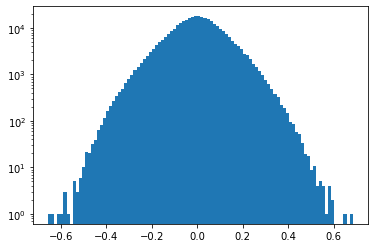

In [103]:
plt.hist(full_corr.detach().cpu().numpy().flatten(), log=True, bins=100);

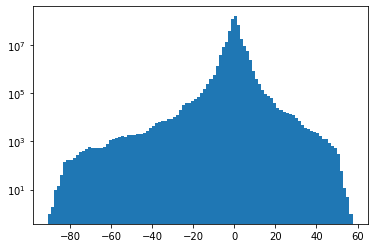

In [104]:
plt.hist(neuron_acts.detach().cpu().numpy().flatten(), log=True, bins=100);

In [33]:
neuron_acts.shape

torch.Size([11008, 39585])

In [76]:
def pearson_correlation(matrix, target):
    n, d = matrix.size()
    target = target.view(-1, 1)  # reshape target to a column vector
    
    # Calculate the sums
    sum_x = matrix.sum(dim=0)
    sum_y = target.sum()
    sum_xy = (matrix * target).sum(dim=0)
    sum_xx = (matrix * matrix).sum(dim=0)
    sum_yy = (target * target).sum()
    
    # Compute the Pearson correlation for each column
    numerator = n * sum_xy - sum_x * sum_y
    denominator = torch.sqrt((n * sum_xx - sum_x ** 2) * (n * sum_yy - sum_y ** 2))
    
    correlation = numerator / denominator
    return correlation

# Example Usage:
matrix = torch.randn((5, 3))  # Example n x d matrix
target = torch.randn(5)  # Example length n vector

correlation_vector = spearman_correlation(matrix, target)
print(correlation_vector)

# check against scipy
from scipy.stats import pearsonr, spearmanr

for i in range(3):
    print(spearmanr(matrix[:, i], target))

tensor([-0.2000,  0.5000, -1.0000])
SignificanceResult(statistic=-0.19999999999999998, pvalue=0.747060078104662)
SignificanceResult(statistic=0.49999999999999994, pvalue=0.39100221895577053)
SignificanceResult(statistic=-0.9999999999999999, pvalue=1.4042654220543672e-24)


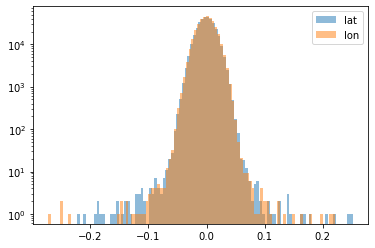

In [11]:
plt.hist(lat_out_comp.flatten().numpy(), bins=100, log=True, alpha=0.5, label='lat');
plt.hist(lon_out_comp.flatten().numpy(), bins=100, log=True, alpha=0.5, label='lon');
plt.legend()

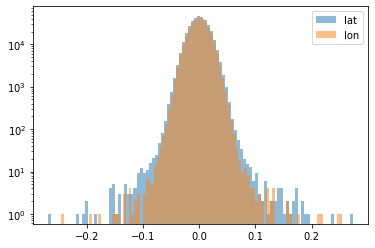

In [12]:
plt.hist(lat_in_comp.flatten().numpy(), bins=100, log=True, alpha=0.5, label='lat');
plt.hist(lon_in_comp.flatten().numpy(), bins=100, log=True, alpha=0.5, label='lon');
plt.legend()

In [13]:
max_vals, max_ixs = lon_in_comp.flatten().abs().argsort()

In [10]:
n_layers, d_model, d_mlp = model.W_in.shape
#top_layers, top_neurons = np.unravel_index(lon_in_comp.flatten().abs().argsort()[-20:], (n_layers, d_mlp))

In [11]:
import einops

def get_top_neurons(learned_probes, model, k=50, W_in=True):
    if W_in:
        W_norm = (model.W_in / model.W_in.norm(dim=1, keepdim=True)).swapaxes(1, 2)
    else:
        W_norm = (model.W_out / model.W_out.norm(dim=-1, keepdim=True))

    n_layers, d_mlp, d_model = W_norm.shape

    W_comp = einops.einsum(W_norm, learned_probes.float(), 'l1 m d, l2 d-> l2 l1 m')

    top_neurons = W_comp.flatten().abs().argsort()
    _, top_layers, top_neurons = np.unravel_index(top_neurons[-k:], (learned_probes.shape[0], n_layers, d_mlp))
    return top_layers, top_neurons

In [13]:
from save_activations import load_activation_probing_dataset
entity_activations = {l: load_activation_probing_dataset(model_name, 'world_place', 'coords', l).dequantize() for l in range(n_layers)}


In [14]:
from scipy.stats import spearmanr

def make_correlation_df(model, features, entity_activations, top_layers, top_neurons, W_in=True):
    neuron_corr = {}
    for l, n in zip(top_layers, top_neurons):
        if W_in:
            neuron_probe = model.W_in[l, :, n]
        else:
            neuron_probe = model.W_out[l, n, :]
            
        for activation_layer, activations in entity_activations.items():
            neuron_probe_projection = activations @ neuron_probe
            corr = spearmanr(neuron_probe_projection, features).correlation
            neuron_corr[(l, n, activation_layer)] = corr

    corr_df = pd.DataFrame({'corr': pd.Series(neuron_corr)})
    corr_df.index.names= ['neuron_layer', 'neuron', 'activation_layer']
    corr_df = corr_df.reset_index()
    return corr_df

In [223]:
lat_probes = torch.stack([torch.tensor(probe_result['probe_directions'][layer][:, 0]) for layer in range(15, model.cfg.n_layers)])
top_layer, top_neurons = get_top_neurons(lat_probes, model, k=50, W_in=True)

In [224]:
feature_values = world_df.longitude.values
corr_df = make_correlation_df(feature_values, entity_activations, top_layers, top_neurons)

TypeError: make_correlation_df() missing 1 required positional argument: 'top_neurons'

In [15]:
def place_neuron_correlations(model, probe_result, place_df, entity_activations, top_k=50, start_layer=15):
    place_lon = place_df.longitude.values
    place_lat = place_df.latitude.values

    lon_probes = torch.stack([
        torch.tensor(probe_result['probe_directions'][layer][:, 1]) 
        for layer in range(start_layer, model.cfg.n_layers)
    ])
    lon_probes = lon_probes / lon_probes.norm(dim=1, keepdim=True)

    lat_probes = torch.stack([
        torch.tensor(probe_result['probe_directions'][layer][:, 1]) 
        for layer in range(start_layer, model.cfg.n_layers)
    ])
    lat_probes = lat_probes / lat_probes.norm(dim=1, keepdim=True)

    top_neuron_dict = {
        ('lon', 'in'): get_top_neurons(lon_probes, model, k=top_k, W_in=True),
        ('lon', 'out'): get_top_neurons(lon_probes, model, k=top_k, W_in=False),
        ('lat', 'in'): get_top_neurons(lat_probes, model, k=top_k, W_in=True),
        ('lat', 'out'): get_top_neurons(lat_probes, model, k=top_k, W_in=False),
    }

    corr_dfs = []
    for (feature, neuron_weight), (top_layers, top_neurons) in top_neuron_dict.items():
        feature_col = 'latitude' if feature == 'lat' else 'longitude'
        use_Win = neuron_weight == 'in'
        feature_values = place_df[feature_col].values

        corr_df = make_correlation_df(model, feature_values, entity_activations, top_layers, top_neurons, W_in=use_Win)
        corr_df['feature'] = feature
        corr_df['neuron_weight'] = neuron_weight
        corr_dfs.append(corr_df)
    return pd.concat(corr_dfs)

In [22]:
entity_df = load_entity_data('world_place')
corr_df = place_neuron_correlations(model, probe_result, entity_df, entity_activations, top_k=50, start_layer=0)

In [23]:
corr_df['abs_corr'] = np.abs(corr_df['corr'].values)
corr_df.sort_values('abs_corr', ascending=False).groupby(['neuron_layer', 'neuron']).head(1)

neuron_layer  neuron  activation_layer      corr feature neuron_weight  \
144            24     269                24  0.796230     lat           out   
118            26   11811                38  0.566742     lon            in   
8              16    9029                 8  0.517394     lat            in   
105            22    3983                25 -0.493232     lat           out   
146            14    3026                26 -0.488956     lon            in   
288             7    5014                 8 -0.469171     lat            in   
48             19    8587                 8  0.385686     lat            in   
167             6    5475                 7 -0.369866     lat            in   
49              8    4102                 9  0.359788     lat           out   
208            13    9201                 8  0.272016     lat            in   

     abs_corr  
144  0.796230  
118  0.566742  
8    0.517394  
105  0.493232  
146  0.488956  
288  0.469171  
48   0.385686  
167  0.369866  
49   0.359788  
208  0.272016

In [187]:
corr_df.sort_values('corr')

neuron_layer  neuron  activation_layer      corr
408            23    6927                24 -0.447470
409            23    6927                25 -0.440207
407            23    6927                23 -0.423002
410            23    6927                26 -0.410962
406            23    6927                22 -0.406529
..            ...     ...               ...       ...
20             18    7395                20  0.575870
28             18    7395                28  0.577668
22             18    7395                22  0.580726
29             18    7395                29  0.585796
30             18    7395                30  0.592871

[640 rows x 4 columns]

In [188]:
corr_df.query('activation_layer <=neuron_layer').sort_values('corr')

neuron_layer  neuron  activation_layer      corr
407            23    6927                23 -0.423002
406            23    6927                22 -0.406529
405            23    6927                21 -0.395457
404            23    6927                20 -0.351978
403            23    6927                19 -0.293975
..            ...     ...               ...       ...
12             18    7395                12  0.465657
16             18    7395                16  0.474256
14             18    7395                14  0.490468
18             18    7395                18  0.498416
17             18    7395                17  0.505543

[347 rows x 4 columns]

In [ ]:
# neuron = (20, 7573) # Llama-7b absolute lat neuron


In [230]:
neuron = (28, 4341)
act_layer = 24
world_df['neuron_probe'] = (entity_activations[act_layer] @ model.W_in[neuron[0], :, neuron[1]] ).numpy()

In [231]:
spearmanr(world_df['neuron_probe'].values, np.abs(world_df['latitude'].values)).correlation

-0.7024352228652504

In [232]:
world_df.sort_values('neuron_probe')#.tail(50)#.query('country != "Australia"').tail(50)

name  entity_subtype         country  \
27072                   Beeston, Leeds  PopulatedPlace  United_Kingdom   
163              Stornoway (residence)         Stadium          Canada   
4603   Bury Castle, Greater Manchester        Building         England   
1166                            SELCHP    PowerStation         England   
5079                  Slack Roman Fort        Building         England   
...                                ...             ...             ...   
11727                    City of Unley          Region       Australia   
11668              City of Onkaparinga          Region       Australia   
22799              Tigre, Buenos Aires  PopulatedPlace       Argentina   
11588        Meningie, South Australia          Region       Australia   
8592                Hamilton, Tasmania          Region       Australia   

       latitude  longitude  has_thumbnail  page_views      entity_type  \
27072   53.7761   -1.55590              1     55487.0  populated_place   
163     45.4528  -75.67860              1    102653.0        structure   
4603    53.5937   -2.29703              1      9872.0        structure   
1166    51.4856   -0.04840              1      9735.0        structure   
5079    53.6540   -1.87200              0      7079.0        structure   
...         ...        ...            ...         ...              ...   
11727  -34.9500  138.60000              1     10799.0  populated_place   
11668  -34.9167  138.63300              1     26755.0  populated_place   
22799  -34.4167  -58.58330              1    123406.0  populated_place   
11588  -35.6883  139.33800              1     21399.0  populated_place   
8592   -42.5560  146.83400              1      7701.0  populated_place   

       total_area  population  is_test            corr  neuron_probe  
27072         NaN     22187.0    False  tensor(0.2661)     -6.339283  
163           NaN         NaN    False  tensor(0.2661)     -5.649853  
4603          NaN         NaN    False  tensor(0.2661)     -5.636675  
1166          NaN         NaN    False  tensor(0.2661)     -5.569611  
5079          NaN         NaN    False  tensor(0.2661)     -5.419126  
...           ...         ...      ...             ...           ...  
11727         NaN     37721.0    False  tensor(0.2661)      8.335209  
11668         NaN    166766.0     True  tensor(0.2661)      8.352410  
22799         NaN     31106.0    False  tensor(0.2661)      8.514743  
11588         NaN       852.0    False  tensor(0.2661)      8.541183  
8592          NaN       241.0    False  tensor(0.2661)      8.850157  

[39585 rows x 13 columns]

In [233]:
# plotly scatter plot of neuron probe vs latitude
import plotly.express as px
px.scatter(world_df, x='neuron_probe', y='latitude', color='country', hover_name='name')

Text(0, 0.5, 'neuron probe projection')

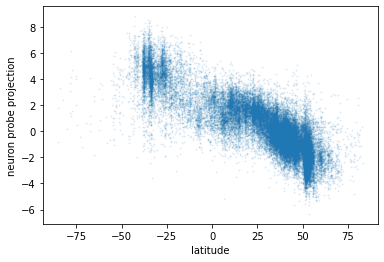

In [234]:
plt.scatter(world_df.latitude.values, world_df.neuron_probe.values, s=1, alpha=0.1)
plt.xlabel('latitude')
plt.ylabel('neuron probe projection')

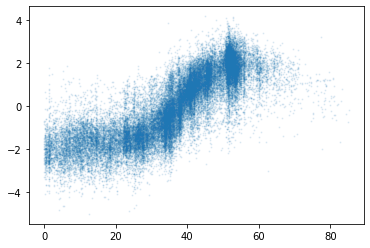

In [214]:
plt.scatter(np.abs(world_df.latitude.values), world_df.neuron_probe.values, s=1, alpha=0.1)

(array([  29.,  321., 2291., 6291., 5480., 5219., 7248., 7326., 1904.,
         103.]),
 array([-4.8533816, -3.9494758, -3.0455697, -2.1416638, -1.2377578,
        -0.3338518,  0.5700542,  1.4739602,  2.377866 ,  3.2817721,
         4.185678 ], dtype=float32),
 <BarContainer object of 10 artists>)

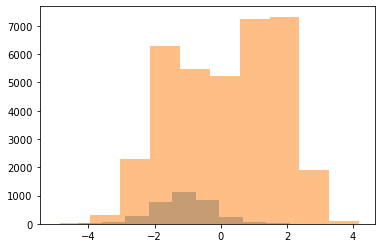

In [195]:
is_australia = world_df.country.values == 'Australia'
plt.hist(world_df.neuron_probe.values[is_australia], alpha=0.5)
plt.hist(world_df.neuron_probe.values[~is_australia], alpha=0.5)


In [14]:
max_layer = max_vals.argmax().item()
max_neuron = max_ixs[max_layer].item()

In [21]:
model.W_in.shape

torch.Size([32, 4096, 11008])

In [15]:
max_layer, max_neuron

(11, 1895)

(array([  25.,  124.,  645., 1899., 3124., 3048., 1579.,  463.,   92.,
           9.]),
 array([-0.06835938, -0.05444336, -0.04052734, -0.02661133, -0.01269531,
         0.0012207 ,  0.01513672,  0.02905273,  0.04296875,  0.05688477,
         0.07080078], dtype=float32),
 <BarContainer object of 10 artists>)

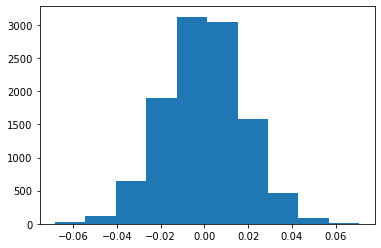

In [16]:
plt.hist(model.W_in[max_layer, max_neuron].numpy())

In [53]:
from save_activations import load_activation_probing_dataset
model_name = 'Llama-2-7b-hf'
world_activations = load_activation_probing_dataset(model_name, 'world_place', 'coords', 25).dequantize()
world_df = load_entity_data('world_place')

In [54]:
neuron_probe = model.W_in[max_layer, :, max_neuron]
neuron_probe_projection = world_activations @ neuron_probe

In [55]:
from scipy.stats import spearmanr

spearmanr(world_df.longitude.values, neuron_probe_projection)

SignificanceResult(statistic=-0.5721538075988407, pvalue=0.0)

In [56]:
neuron_probe_projection

tensor([-0.4367, -2.4678,  1.4474,  ..., -0.5984, -3.2450,  0.4348])

In [ ]:
# dataframe with (neuron layer, neuron probe) layer activations spearman

In [58]:
probe_result['probe_directions'][15]

array([[-0.01415 ,  0.01689 ],
       [ 0.05435 , -0.02287 ],
       [-0.02548 , -0.006405],
       ...,
       [-0.00819 ,  0.00875 ],
       [ 0.00959 , -0.00439 ],
       [ 0.01683 ,  0.011734]], dtype=float16)

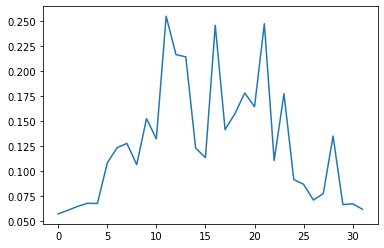

In [43]:
plt.plot(max_vals)

In [133]:
random_probe = torch.randn_like(w_lat_probe)
random_probe = random_probe / random_probe.norm(dim=0, keepdim=True)

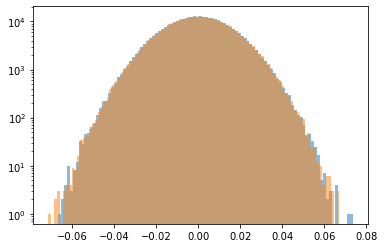

In [134]:
plt.hist((W_out_norm @ random_probe).flatten().numpy(), bins=100, log=True, alpha=0.5);
plt.hist((W_in_norm @ random_probe).flatten().numpy(), bins=100, log=True, alpha=0.5);

In [135]:
W_U_norm = (model.W_U / model.W_U.norm(dim=1, keepdim=True)).T

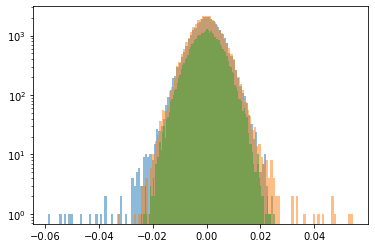

In [136]:
plt.hist((W_U_norm @ w_lat_probe).numpy(), bins=100, log=True, alpha=0.5);
plt.hist((W_U_norm @ w_lon_probe).numpy(), bins=100, log=True, alpha=0.5);
plt.hist((W_U_norm @ random_probe).numpy(), bins=100, log=True, alpha=0.5);

In [137]:
decoded_vocab = {
    tix: model.tokenizer.decode(tix)
    for tix in model.tokenizer.get_vocab().values()
}


In [138]:
top_lon = (W_U_norm @ w_lon_probe).numpy().argsort()
top_lat = (W_U_norm @ w_lat_probe).numpy().argsort()

In [139]:
for i in range(20):
    print(decoded_vocab[top_lon[i]], decoded_vocab[top_lat[i]])

Mexican Austral
Mexico austral
Mex Austral
Unidos Melbourne
California Australia
Chile Australian
lio Queensland
Canadian Sydney
Latin Tas
Atlantic Ng
Насеље ustral
United Aus
Slo syd
Colleg South
segu AU
Indian Aus
adre oko
Ana Buenos
Sierra Mau
county Argentina


In [140]:
for i in range(1, 20):
    print(decoded_vocab[top_lon[-i]], decoded_vocab[top_lat[-i]])

Australia 漢
Austral arz
Queensland atori
Australian ugin
austral Euro
Austral Han
Melbourne Balt
Tas Mold
Sydney Errors
Aus lieder
ustral euro
Aus rn
Asia Glas
organis Bilder
Ав Ham
Zealand ë
Organisation nia
syd Nord
Wang Ain
